In [1]:
!pip install pandas>=2.2 git+https://github.com/Nixtla/neuralforecast.git

  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast.git /tmp/pip-req-build-ynyo80he
  Running command git submodule update --init --recursive -q


In [2]:
from sqlalchemy import create_engine
import pandas as pd
import torch
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


# 防止gpu内存不足中断训练
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [22]:
import pandas as pd
from sqlalchemy import create_engine


database_url = "sqlite:////content/data.sqlite"
# database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)
# 从数据库读取数据
query = "select date as ds, global_entry, hkmo_entry, tw_entry from sh_visitors_daily"
original_data = pd.read_sql_query(query, engine, index_col='ds', parse_dates=['ds'])

# 复制数据
df = original_data.copy()

# 删除指定日期范围内的数据
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2023-06-01')

# 使用布尔索引选择不在指定范围内的数据
df = df.loc[(df.index < start_date) | (df.index > end_date)].sort_index()

# 创建一个递减的日期索引
new_index = pd.date_range(end=df.index.max(), periods=len(df))
# new_index = new_index.sort_values(ascending=False)  # 逆序排序以创建递减索引

# 将新的日期索引应用到数据框架
df.set_index(new_index, inplace=True)

# 转换为长格式
df_long = pd.melt(df.reset_index(), id_vars=['index'], var_name='unique_id', value_name='y')
df_long.rename(columns={'index': 'ds'}, inplace=True)

# 检查代码
print(df_long.head())

          ds     unique_id      y
0 2014-06-02  global_entry  11430
1 2014-06-03  global_entry  11460
2 2014-06-04  global_entry  12266
3 2014-06-05  global_entry  12951
4 2014-06-06  global_entry  12751


In [29]:
from neuralforecast.auto import AutoLSTM, AutoInformer, AutoAutoformer, AutoPatchTST, AutoiTransformer
from ray import tune
from neuralforecast.core import NeuralForecast

horizon = 60
lstm_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "encoder_hidden_size": tune.choice([50, 100, 200]),
    "encoder_n_layers": tune.randint(1, 4),
    "context_size": tune.choice([5, 10, 50]),
    "decoder_hidden_size": tune.choice([64, 128, 256]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "max_steps": tune.choice([300, 500, 700]),
    "batch_size": tune.choice([16, 32]),
    "random_seed": tune.randint(1, 20),
}

informer_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "hidden_size": tune.choice([64, 128, 256]),
    "n_head": tune.choice([4, 8]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "scaler_type": tune.choice(["robust", "minmax"]),
    "max_steps": tune.choice([300, 500, 1000]),
    "batch_size": tune.choice([32, 64, 128]),
    "windows_batch_size": tune.choice([128, 256, 512]),
    "random_seed": tune.randint(1, 20),
}

autoformer_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "hidden_size": tune.choice([64, 128, 256]),
    "n_head": tune.choice([4, 8]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "scaler_type": tune.choice(["robust", "standard", "minmax"]),
    "max_steps": tune.choice([300, 500, 1000]),
    "batch_size": tune.choice([32, 64, 128]),
    "windows_batch_size": tune.choice([128, 256, 512]),
    "random_seed": tune.randint(1, 20),
}

pathtst_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "hidden_size": tune.choice([64, 128, 256]),
    "n_heads": tune.choice([4, 8]),
    "patch_len": tune.choice([16, 24]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "scaler_type": tune.choice([None, "robust", "standard"]),
    "revin": True,
    "revin_affine": tune.choice([True, False]),
    "max_steps": tune.choice([500, 700, 1000]),
    "batch_size": tune.choice([32, 64, 128]),
    "windows_batch_size": tune.choice([128, 256, 512]),
    "random_seed": tune.randint(1, 20),
}

itransformer_config = {
    "input_size": tune.choice([horizon, horizon * 2]),
    "n_series": 3,
    "hidden_size": tune.choice([64, 128, 256]),
    "n_heads": tune.choice([4, 8]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "scaler_type": tune.choice(["robust", "standard", "minmax"]),
    "max_steps": tune.choice([500, 700, 1000]),
    "batch_size": tune.choice([32, 64, 128]),
    "loss": None,
    "random_seed": tune.randint(1, 20),
}

models = [
    # baseline
    AutoLSTM(
        h=horizon,  # input size has a multiplier, 1~5
        config=lstm_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    ),
    # transformer-based model1
    AutoInformer(
        h=horizon,  # input size has a multiplier, 1~5
        config=informer_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    ),
    # transformer-based model2
    AutoAutoformer(
        h=horizon,  # input size has a multiplier, 1~5
        config=autoformer_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    ),
    # transformer-based model3
    AutoPatchTST(
        h=horizon,  # input size has a multiplier, 1~5
        config=pathtst_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    ),
    # transformer-based model4
    AutoiTransformer(
        h=horizon,  # input size has a multiplier, 1~5
        n_series=3,
        config=itransformer_config,
        # loss= 'mae', # default is MAE
        verbose=True,  # track progress
        num_samples=5,  # try 5
        backend='ray'
    )
]

nf = NeuralForecast(
    models=models,
    freq='1D',
)
cross_val = nf.cross_validation(df_long, val_size=int(0.1 * len(df_long)))

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
2024-04-18 23:58:46,133	INFO tune.py:633 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-18_23-58-46   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-18_23-58-46
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-18_23-58-46/_train_tune_2024-04-18_23-58-46/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-18 23:58:46. Total running time: 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=13524) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=13524) Seed set to 16
(_train_tune pid=13524) GPU available: True (cuda), used: True
(_train_tune pid=13524) TPU available: False, using: 0 TPU cores
(_train_tune pid=13524) IPU available: False, using: 0 IPUs
(_train_tune pid=13524) HPU available: False, using: 0 HPUs
(_train_tune pid=13524) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-18_23-58-46/_train_tune_2024-04-18_23-58-46/working_dirs/_train_tune_947f4_00000_0_batch_size=16,context_size=50,decoder_hidden_size=128,encoder_hidden_size=100,encoder_n_layers=3,input_s_2024-04-18_23-58-46/lightning_logs
(_train_tune pid=13524) 2024-04-18 23:58:52.469593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 125.35it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.01it/s]
(_train_tune pid=13524) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 131.51it/s, v_num=0, train_loss_step=1.090, train_loss_epoch=1.100, valid_loss=1.51e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13524) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 129.11it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=0.849, valid_loss=1.55e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 129.58it/s, v_num=0, train_loss_step=0.950, train_loss_epoch=1.160, valid_loss=1.51e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 132.09it/s, v_num=0, train_loss_step=0.771, train_loss_epoch=0.946, val

(_train_tune pid=13524) `Trainer.fit` stopped: `max_steps=700` reached.


(_train_tune pid=13524) 
Epoch 699: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s, v_num=0, train_loss_step=0.791, train_loss_epoch=0.791, valid_loss=1.39e+3]

Trial _train_tune_947f4_00001 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947f4_00001 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| context_size                                   5 |
| decoder_hidden_size                           64 |
| encoder_hidden_size                          100 |
| encoder_n_layers                               2 |
| h                                             60 |
| input_size                                    60 |
| learning_rate                            0.00956 |
| loss                                       MAE() |
| max_steps                                    300 |
| random_seed                                    7 |
| valid_loss                             

(_train_tune pid=13636) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=13636) Seed set to 7
(_train_tune pid=13636) GPU available: True (cuda), used: True
(_train_tune pid=13636) TPU available: False, using: 0 TPU cores
(_train_tune pid=13636) IPU available: False, using: 0 IPUs
(_train_tune pid=13636) HPU available: False, using: 0 HPUs
(_train_tune pid=13636) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-18_23-58-46/_train_tune_2024-04-18_23-58-46/working_dirs/_train_tune_947f4_00001_1_batch_size=16,context_size=5,decoder_hidden_size=64,encoder_hidden_size=100,encoder_n_layers=2,input_siz_2024-04-18_23-58-46/lightning_logs
(_train_tune pid=13636) 2024-04-18 23:59:08.455178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 134.10it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 142.86it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=0.810, valid_loss=1.75e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 144.04it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=0.894, valid_loss=1.73e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial _train_tune_947f4_00001 completed after 3 iterations at 2024-04-18 23:59:13. Total running time: 27s
+--------------------------------------------------+
| Trial _train_tune_947f4_00001 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         0.87779 |
| time_total_s                             6.

(_train_tune pid=13636) `Trainer.fit` stopped: `max_steps=300` reached.



Trial status: 2 TERMINATED | 3 PENDING
Current time: 2024-04-18 23:59:16. Total running time: 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947f4_00000 with loss=1394.8353271484375 and params={'input_size': 120, 'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.0017065559039587859, 'max_steps': 700, 'batch_size': 16, 'random_seed': 16, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     encoder_hidden_size     encoder_n_layers     context_size     decoder_hidden_size     learning_rate     max_steps     batch_size     random_seed     iter     total time (s)     

(_train_tune pid=13731) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=13731) Seed set to 1
(_train_tune pid=13731) GPU available: True (cuda), used: True
(_train_tune pid=13731) TPU available: False, using: 0 TPU cores
(_train_tune pid=13731) IPU available: False, using: 0 IPUs
(_train_tune pid=13731) HPU available: False, using: 0 HPUs
(_train_tune pid=13731) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-18_23-58-46/_train_tune_2024-04-18_23-58-46/working_dirs/_train_tune_947f4_00002_2_batch_size=16,context_size=10,decoder_hidden_size=64,encoder_hidden_size=100,encoder_n_layers=2,input_si_2024-04-18_23-58-46/lightning_logs
(_train_tune pid=13731) 2024-04-18 23:59:20.343390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 145.47it/s, v_num=0, train_loss_step=0.959, train_loss_epoch=0.895]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13731) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 145.13it/s, v_num=0, train_loss_step=1.260, train_loss_epoch=1.140, valid_loss=1.6e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 144.18it/s, v_num=0, train_loss_step=1.100, train_loss_epoch=1.130, valid_loss=1.51e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 148.15it/s, v_num=0, train_loss_step=1.380, train_loss_epoch=1.190, valid_loss=1.51e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13731) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 105.34it/s, v_num=0, train_lo

(_train_tune pid=13731) `Trainer.fit` stopped: `max_steps=700` reached.



Trial _train_tune_947f4_00003 started with configuration:
+-------------------------------------------------+
| Trial _train_tune_947f4_00003 config            |
+-------------------------------------------------+
| batch_size                                   32 |
| context_size                                  5 |
| decoder_hidden_size                         128 |
| encoder_hidden_size                         100 |
| encoder_n_layers                              1 |
| h                                            60 |
| input_size                                   60 |
| learning_rate                            0.0009 |
| loss                                      MAE() |
| max_steps                                   700 |
| random_seed                                   2 |
| valid_loss                                MAE() |
+-------------------------------------------------+


(_train_tune pid=13841) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=13841) Seed set to 2
(_train_tune pid=13841) GPU available: True (cuda), used: True
(_train_tune pid=13841) TPU available: False, using: 0 TPU cores
(_train_tune pid=13841) IPU available: False, using: 0 IPUs
(_train_tune pid=13841) HPU available: False, using: 0 HPUs
(_train_tune pid=13841) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-18_23-58-46/_train_tune_2024-04-18_23-58-46/working_dirs/_train_tune_947f4_00003_3_batch_size=32,context_size=5,decoder_hidden_size=128,encoder_hidden_size=100,encoder_n_layers=1,input_si_2024-04-18_23-58-46/lightning_logs
(_train_tune pid=13841) 2024-04-18 23:59:36.346596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 152.35it/s, v_num=0, train_loss_step=0.960, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 147.10it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.390, valid_loss=1.51e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 154.13it/s, v_num=0, train_loss_step=1.400, train_loss_epoch=1.070, valid_loss=1.49e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13841) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 144.89it/s, v_num=0, train_loss_step=1.130, train_loss_epoch=1.410, valid_loss=1.51e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13841) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 152.01it/s, v_num=0, train_loss_step=1.120, train_loss_epoch=0.846, valid_loss=

(_train_tune pid=13841) `Trainer.fit` stopped: `max_steps=700` reached.



Trial status: 4 TERMINATED | 1 PENDING
Current time: 2024-04-18 23:59:46. Total running time: 1min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947f4_00000 with loss=1394.8353271484375 and params={'input_size': 120, 'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.0017065559039587859, 'max_steps': 700, 'batch_size': 16, 'random_seed': 16, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     encoder_hidden_size     encoder_n_layers     context_size     decoder_hidden_size     learning_rate     max_steps     batch_size     random_seed     iter     total time (s) 

(_train_tune pid=13948) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=13948) Seed set to 2
(_train_tune pid=13948) GPU available: True (cuda), used: True
(_train_tune pid=13948) TPU available: False, using: 0 TPU cores
(_train_tune pid=13948) IPU available: False, using: 0 IPUs
(_train_tune pid=13948) HPU available: False, using: 0 HPUs
(_train_tune pid=13948) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-18_23-58-46/_train_tune_2024-04-18_23-58-46/working_dirs/_train_tune_947f4_00004_4_batch_size=16,context_size=10,decoder_hidden_size=64,encoder_hidden_size=200,encoder_n_layers=1,input_si_2024-04-18_23-58-46/lightning_logs
(_train_tune pid=13948) 2024-04-18 23:59:51.385908: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 133.36it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13948) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 123.36it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.590, valid_loss=1.79e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=13948) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=13948) 
Epoch 285:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.020, train_loss_epoch=1.020, valid_loss=1.75e+3]


(_train_tune pid=13948) `Trainer.fit` stopped: `max_steps=300` reached.
2024-04-18 23:59:57,202	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-18 23:59:57,205	INFO tune.py:1021 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-18_23-58-46' in 0.0074s.
INFO:lightning_fabric.utilities.seed:Seed set to 16
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utili

Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 119.40it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.040, valid_loss=1.75e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s, v_num=0, train_loss_step=1.620, train_loss_epoch=1.620, valid_loss=1.75e+3]

Trial _train_tune_947f4_00004 completed after 3 iterations at 2024-04-18 23:59:57. Total running time: 1min 11s
+--------------------------------------------------+
| Trial _train_tune_947f4_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         0.99435 |
| time_total_s                             6.92112 |
| training_iteration                             3 |
| loss                                     1749.39 |
| train_loss                               1.61519 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 20

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=700` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-19 00:00:09,845	INFO tune.py:633 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-19_00-00-09   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-19_00-00-09
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-00-09/_train_tune_2024-04-19_00-00-09/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-19 00:00:10. Total running time: 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=14093) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14093) Seed set to 17
(_train_tune pid=14093) GPU available: True (cuda), used: True
(_train_tune pid=14093) TPU available: False, using: 0 TPU cores
(_train_tune pid=14093) IPU available: False, using: 0 IPUs
(_train_tune pid=14093) HPU available: False, using: 0 HPUs
(_train_tune pid=14093) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-00-09/_train_tune_2024-04-19_00-00-09/working_dirs/_train_tune_947fd_00000_0_batch_size=128,hidden_size=128,input_size=120,learning_rate=0.0007,max_steps=500,n_head=8,random_seed=17_2024-04-19_00-00-09/lightning_logs
(_train_tune pid=14093) 2024-04-19 00:00:16.068023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 14.64it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14093) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s, v_num=0, train_loss_step=1.110, train_loss_epoch=1.100, valid_loss=1.27e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14093) 
Epoch 293:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.030, train_loss_epoch=1.030, valid_loss=1.21e+3]

Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-04-19 00:00:40. Total running time: 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00000 with loss=1212.6842041015625 and params={'input_size': 120, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.0007048822052220307, 'scaler_type': 'robust',

(_train_tune pid=14093) `Trainer.fit` stopped: `max_steps=500` reached.


(_train_tune pid=14093) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, v_num=0, train_loss_step=1.030, train_loss_epoch=1.030, valid_loss=1.16e+3]

Trial _train_tune_947fd_00001 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947fd_00001 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| h                                             60 |
| hidden_size                                   64 |
| input_size                                    60 |
| learning_rate                            0.00047 |
| loss                                       MAE() |
| max_steps                                    500 |
| n_head                                         4 |
| random_seed                                    1 |
| scaler_type                               robust |
| valid_loss                                 MAE() |
| windows_batch_size                     

(_train_tune pid=14330) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14330) Seed set to 1
(_train_tune pid=14330) GPU available: True (cuda), used: True
(_train_tune pid=14330) TPU available: False, using: 0 TPU cores
(_train_tune pid=14330) IPU available: False, using: 0 IPUs
(_train_tune pid=14330) HPU available: False, using: 0 HPUs
(_train_tune pid=14330) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-00-09/_train_tune_2024-04-19_00-00-09/working_dirs/_train_tune_947fd_00001_1_batch_size=32,hidden_size=64,input_size=60,learning_rate=0.0005,max_steps=500,n_head=4,random_seed=1,sca_2024-04-19_00-00-09/lightning_logs
(_train_tune pid=14330) 2024-04-19 00:01:01.417609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 37.52it/s, v_num=0, train_loss_step=1.430, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 187:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.340, train_loss_epoch=1.340, valid_loss=1.28e+3]

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-19 00:01:10. Total running time: 1min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00000 with loss=1163.794189453125 and params={'input_size': 120, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.0007048822052220307, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 512, 'random_seed': 17, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(_train_tune pid=14330) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_947fd_00002 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947fd_00002 config             |
+--------------------------------------------------+
| batch_size                                    64 |
| h                                             60 |
| hidden_size                                   64 |
| input_size                                   120 |
| learning_rate                            0.01788 |
| loss                                       MAE() |
| max_steps                                    300 |
| n_head                                         4 |
| random_seed                                    5 |
| scaler_type                               robust |
| valid_loss                                 MAE() |
| windows_batch_size                           128 |
+--------------------------------------------------+


(_train_tune pid=14478) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14478) Seed set to 5
(_train_tune pid=14478) GPU available: True (cuda), used: True
(_train_tune pid=14478) TPU available: False, using: 0 TPU cores
(_train_tune pid=14478) IPU available: False, using: 0 IPUs
(_train_tune pid=14478) HPU available: False, using: 0 HPUs
(_train_tune pid=14478) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-00-09/_train_tune_2024-04-19_00-00-09/working_dirs/_train_tune_947fd_00002_2_batch_size=64,hidden_size=64,input_size=120,learning_rate=0.0179,max_steps=300,n_head=4,random_seed=5,sc_2024-04-19_00-00-09/lightning_logs
(_train_tune pid=14478) 2024-04-19 00:01:26.374968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s, v_num=0, train_loss_step=1.460, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14478) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 37.68it/s, v_num=0, train_loss_step=1.380, train_loss_epoch=1.390, valid_loss=1.66e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14478) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 34.44it/s, v_num=0, train_loss_step=1.360, train_loss_epoch=1.390, valid_loss=1.51e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial _train_tune_947fd_00002 completed after 3 iterations at 2024-04-19 00:01:38. Total running time: 1min 28s
+--------------------------------------------------+
| Trial _train_tune_947fd_00002 result             |
+-------------------------

(_train_tune pid=14478) `Trainer.fit` stopped: `max_steps=300` reached.



Trial status: 3 TERMINATED | 2 PENDING
Current time: 2024-04-19 00:01:40. Total running time: 1min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00001 with loss=1141.3385009765625 and params={'input_size': 60, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.00046894984211662906, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 1, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     windows_batch_size     random_seed     iter     total time (s)      loss     train_loss |
+---------------------------

(_train_tune pid=14596) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14596) Seed set to 19
(_train_tune pid=14596) GPU available: True (cuda), used: True
(_train_tune pid=14596) TPU available: False, using: 0 TPU cores
(_train_tune pid=14596) IPU available: False, using: 0 IPUs
(_train_tune pid=14596) HPU available: False, using: 0 HPUs
(_train_tune pid=14596) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-00-09/_train_tune_2024-04-19_00-00-09/working_dirs/_train_tune_947fd_00003_3_batch_size=64,hidden_size=128,input_size=120,learning_rate=0.0003,max_steps=500,n_head=8,random_seed=19,_2024-04-19_00-00-09/lightning_logs
(_train_tune pid=14596) 2024-04-19 00:01:45.492134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 33.14it/s, v_num=0, train_loss_step=1.220, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14596) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 31.00it/s, v_num=0, train_loss_step=1.200, train_loss_epoch=1.160, valid_loss=1.25e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14596) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.120, valid_loss=1.22e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14596) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]
(_train_tune pid=14596) 
                                                                      
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 33.43it

(_train_tune pid=14596) `Trainer.fit` stopped: `max_steps=500` reached.



Trial status: 4 TERMINATED | 1 PENDING
Current time: 2024-04-19 00:02:10. Total running time: 2min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00001 with loss=1141.3385009765625 and params={'input_size': 60, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.00046894984211662906, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 1, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     windows_batch_size     random_seed     iter     total time (s)      loss     train_loss |
+----------------------------

(_train_tune pid=14753) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14753) Seed set to 13
(_train_tune pid=14753) GPU available: True (cuda), used: True
(_train_tune pid=14753) TPU available: False, using: 0 TPU cores
(_train_tune pid=14753) IPU available: False, using: 0 IPUs
(_train_tune pid=14753) HPU available: False, using: 0 HPUs
(_train_tune pid=14753) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-00-09/_train_tune_2024-04-19_00-00-09/working_dirs/_train_tune_947fd_00004_4_batch_size=64,hidden_size=64,input_size=120,learning_rate=0.0140,max_steps=500,n_head=4,random_seed=13,s_2024-04-19_00-00-09/lightning_logs
(_train_tune pid=14753) 2024-04-19 00:02:12.544141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 31.67it/s, v_num=0, train_loss_step=0.198, train_loss_epoch=0.197]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14753) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 30.07it/s, v_num=0, train_loss_step=0.198, train_loss_epoch=0.198, valid_loss=1.67e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14753) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s, v_num=0, train_loss_step=0.205, train_loss_epoch=0.202, valid_loss=1.71e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14753) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 31.65it/s, v_num=0, train_loss_step=0.195, train_loss_epoch=0.183, valid_loss=1.66e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          |

(_train_tune pid=14753) `Trainer.fit` stopped: `max_steps=500` reached.
2024-04-19 00:02:33,215	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-19 00:02:33,217	INFO tune.py:1021 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-19_00-00-09' in 0.0065s.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilit

(_train_tune pid=14753) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s, v_num=0, train_loss_step=0.177, train_loss_epoch=0.177, valid_loss=1.51e+3]

Trial _train_tune_947fd_00004 completed after 5 iterations at 2024-04-19 00:02:33. Total running time: 2min 23s
+--------------------------------------------------+
| Trial _train_tune_947fd_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         3.54037 |
| time_total_s                             21.7413 |
| training_iteration                             5 |
| loss                                     1507.69 |
| train_loss                               0.17741 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-19 00:02:33. Total running time: 2min 23s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_0000

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-19 00:02:53,010	INFO tune.py:633 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-19_00-02-53   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-19_00-02-53
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-02-53/_train_tune_2024-04-19_00-02-53/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-19 00:02:53. Total running time: 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=14997) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14997) Seed set to 16
(_train_tune pid=14997) GPU available: True (cuda), used: True
(_train_tune pid=14997) TPU available: False, using: 0 TPU cores
(_train_tune pid=14997) IPU available: False, using: 0 IPUs
(_train_tune pid=14997) HPU available: False, using: 0 HPUs
(_train_tune pid=14997) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-02-53/_train_tune_2024-04-19_00-02-53/working_dirs/_train_tune_947fd_00000_0_batch_size=128,hidden_size=256,input_size=120,learning_rate=0.0194,max_steps=1000,n_head=8,random_seed=1_2024-04-19_00-02-53/lightning_logs
(_train_tune pid=14997) 2024-04-19 00:02:59.475372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s, v_num=0, train_loss_step=0.327, train_loss_epoch=0.341]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14997) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s, v_num=0, train_loss_step=0.229, train_loss_epoch=0.226, valid_loss=2.17e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14997) 
Epoch 228:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.236, train_loss_epoch=0.236, valid_loss=1.75e+3]

Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-04-19 00:03:23. Total running time: 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00000 with loss=1746.1436767578125 and params={'input_size': 120, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.019391470906264245, 'scaler_type': 'minmax', 

(_train_tune pid=14997) `Trainer.fit` stopped: `max_steps=1000` reached.



Trial _train_tune_947fd_00001 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_947fd_00001 config              |
+---------------------------------------------------+
| batch_size                                     32 |
| h                                              60 |
| hidden_size                                   128 |
| input_size                                     60 |
| learning_rate                             0.01145 |
| loss                                        MAE() |
| max_steps                                    1000 |
| n_head                                          4 |
| random_seed                                    13 |
| scaler_type                              standard |
| valid_loss                                  MAE() |
| windows_batch_size                            128 |
+---------------------------------------------------+


(_train_tune pid=15467) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=15467) Seed set to 13
(_train_tune pid=15467) GPU available: True (cuda), used: True
(_train_tune pid=15467) TPU available: False, using: 0 TPU cores
(_train_tune pid=15467) IPU available: False, using: 0 IPUs
(_train_tune pid=15467) HPU available: False, using: 0 HPUs
(_train_tune pid=15467) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-02-53/_train_tune_2024-04-19_00-02-53/working_dirs/_train_tune_947fd_00001_1_batch_size=32,hidden_size=128,input_size=60,learning_rate=0.0115,max_steps=1000,n_head=4,random_seed=13,_2024-04-19_00-02-53/lightning_logs
(_train_tune pid=15467) 2024-04-19 00:04:37.603563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s, v_num=0, train_loss_step=1.090, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15467) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s, v_num=0, train_loss_step=1.090, train_loss_epoch=1.110, valid_loss=1.62e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15467) 
Epoch 251:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=1.080, valid_loss=1.64e+3]

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-19 00:04:53. Total running time: 2min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00001 with loss=1636.420166015625 and params={'input_size': 60, 'hidden_size': 128, 'n_head':

(_train_tune pid=15467) `Trainer.fit` stopped: `max_steps=1000` reached.



Trial _train_tune_947fd_00002 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_947fd_00002 config              |
+---------------------------------------------------+
| batch_size                                     32 |
| h                                              60 |
| hidden_size                                   128 |
| input_size                                     60 |
| learning_rate                             0.00958 |
| loss                                        MAE() |
| max_steps                                     500 |
| n_head                                          8 |
| random_seed                                     6 |
| scaler_type                              standard |
| valid_loss                                  MAE() |
| windows_batch_size                            256 |
+---------------------------------------------------+


(_train_tune pid=15773) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=15773) Seed set to 6
(_train_tune pid=15773) GPU available: True (cuda), used: True
(_train_tune pid=15773) TPU available: False, using: 0 TPU cores
(_train_tune pid=15773) IPU available: False, using: 0 IPUs
(_train_tune pid=15773) HPU available: False, using: 0 HPUs
(_train_tune pid=15773) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-02-53/_train_tune_2024-04-19_00-02-53/working_dirs/_train_tune_947fd_00002_2_batch_size=32,hidden_size=128,input_size=60,learning_rate=0.0096,max_steps=500,n_head=8,random_seed=6,sc_2024-04-19_00-02-53/lightning_logs
(_train_tune pid=15773) 2024-04-19 00:05:37.528324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15773) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 20.39it/s, v_num=0, train_loss_step=1.090, train_loss_epoch=1.070, valid_loss=1.63e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15773) 
Epoch 234:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.040, train_loss_epoch=1.040, valid_loss=1.61e+3]

Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-04-19 00:05:53. Total running time: 3min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00002 with loss=1605.533447265625 and params={'input_size': 60, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.009580125971520649, 'scaler_

(_train_tune pid=15773) `Trainer.fit` stopped: `max_steps=500` reached.


(_train_tune pid=15773) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=1.140, valid_loss=1.62e+3]

Trial _train_tune_947fd_00002 completed after 5 iterations at 2024-04-19 00:06:08. Total running time: 3min 15s
+--------------------------------------------------+
| Trial _train_tune_947fd_00002 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         5.46467 |
| time_total_s                             31.6943 |
| training_iteration                             5 |
| loss                                      1621.9 |
| train_loss                               1.14464 |
+--------------------------------------------------+

Trial _train_tune_947fd_00003 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947fd_00003 config             |
+---------------------------------

(_train_tune pid=15979) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=15979) Seed set to 13
(_train_tune pid=15979) GPU available: True (cuda), used: True
(_train_tune pid=15979) TPU available: False, using: 0 TPU cores
(_train_tune pid=15979) IPU available: False, using: 0 IPUs
(_train_tune pid=15979) HPU available: False, using: 0 HPUs
(_train_tune pid=15979) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-02-53/_train_tune_2024-04-19_00-02-53/working_dirs/_train_tune_947fd_00003_3_batch_size=128,hidden_size=64,input_size=120,learning_rate=0.0594,max_steps=500,n_head=8,random_seed=13,_2024-04-19_00-02-53/lightning_logs
(_train_tune pid=15979) 2024-04-19 00:06:14.661484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.285]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15979) 
Epoch 109:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=1.75e+3]

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-04-19 00:06:23. Total running time: 3min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00001 with loss=1620.321044921875 and params={'input_size': 60, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.011452152699850442, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 13, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+----------------------------------------------------------------------------------------------------------------------

(_train_tune pid=15979) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_947fd_00004 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947fd_00004 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| h                                             60 |
| hidden_size                                   64 |
| input_size                                   120 |
| learning_rate                            0.00028 |
| loss                                       MAE() |
| max_steps                                    500 |
| n_head                                         8 |
| random_seed                                    5 |
| scaler_type                               robust |
| valid_loss                                 MAE() |
| windows_batch_size                           128 |
+--------------------------------------------------+


(_train_tune pid=16172) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=16172) Seed set to 5
(_train_tune pid=16172) GPU available: True (cuda), used: True
(_train_tune pid=16172) TPU available: False, using: 0 TPU cores
(_train_tune pid=16172) IPU available: False, using: 0 IPUs
(_train_tune pid=16172) HPU available: False, using: 0 HPUs
(_train_tune pid=16172) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-02-53/_train_tune_2024-04-19_00-02-53/working_dirs/_train_tune_947fd_00004_4_batch_size=128,hidden_size=64,input_size=120,learning_rate=0.0003,max_steps=500,n_head=8,random_seed=5,s_2024-04-19_00-02-53/lightning_logs
(_train_tune pid=16172) 2024-04-19 00:06:49.470851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.480, train_loss_epoch=1.480]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-04-19 00:06:53. Total running time: 4min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00001 with loss=1620.321044921875 and params={'input_size': 60, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.011452152699850442, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 13, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type       max_steps     batch_size     windows_bat

2024-04-19 00:07:18,282	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
(_train_tune pid=16172) `Trainer.fit` stopped: `max_steps=500` reached.
2024-04-19 00:07:18,287	INFO tune.py:1021 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-19_00-02-53' in 0.0108s.
INFO:lightning_fabric.utilities.seed:Seed set to 5
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilit

(_train_tune pid=16172) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=1.080, valid_loss=1.47e+3]

Trial status: 5 TERMINATED
Current time: 2024-04-19 00:07:18. Total running time: 4min 25s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fd_00004 with loss=1468.16552734375 and params={'input_size': 120, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.00027727211707552496, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 128, 'random_seed': 5, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_head     learning_rate   scaler_type      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-19 00:07:49,917	INFO tune.py:633 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-19_00-07-49   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-19_00-07-49
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-07-49/_train_tune_2024-04-19_00-07-49/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-19 00:07:50. Total running time: 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=16509) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=16509) Seed set to 2
(_train_tune pid=16509) GPU available: True (cuda), used: True
(_train_tune pid=16509) TPU available: False, using: 0 TPU cores
(_train_tune pid=16509) IPU available: False, using: 0 IPUs
(_train_tune pid=16509) HPU available: False, using: 0 HPUs
(_train_tune pid=16509) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-07-49/_train_tune_2024-04-19_00-07-49/working_dirs/_train_tune_947fe_00000_0_batch_size=32,hidden_size=256,input_size=120,learning_rate=0.0013,max_steps=700,n_heads=4,patch_len=24,r_2024-04-19_00-07-49/lightning_logs
(_train_tune pid=16509) 2024-04-19 00:07:56.078975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s, v_num=0, train_loss_step=542.0, train_loss_epoch=531.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=16509) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 67.45it/s, v_num=0, train_loss_step=394.0, train_loss_epoch=412.0, valid_loss=808.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=16509) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 67.38it/s, v_num=0, train_loss_step=399.0, train_loss_epoch=405.0, valid_loss=737.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.29it/s]
(_train_tune pid=16509) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 65.37it/s, v_num=0, train_loss_step=386.0, train_loss_epoch=423.0, valid_loss=726.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<

(_train_tune pid=16509) `Trainer.fit` stopped: `max_steps=700` reached.


(_train_tune pid=16509) 
Epoch 699: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s, v_num=0, train_loss_step=331.0, train_loss_epoch=331.0, valid_loss=646.0]

Trial _train_tune_947fe_00001 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947fe_00001 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| h                                             60 |
| hidden_size                                  256 |
| input_size                                    60 |
| learning_rate                            0.00604 |
| loss                                       MAE() |
| max_steps                                    500 |
| n_heads                                        4 |
| patch_len                                     24 |
| random_seed                                    4 |
| revin                                       True |
| revin_affine                             

(_train_tune pid=16644) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=16644) Seed set to 4
(_train_tune pid=16644) GPU available: True (cuda), used: True
(_train_tune pid=16644) TPU available: False, using: 0 TPU cores
(_train_tune pid=16644) IPU available: False, using: 0 IPUs
(_train_tune pid=16644) HPU available: False, using: 0 HPUs
(_train_tune pid=16644) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-07-49/_train_tune_2024-04-19_00-07-49/working_dirs/_train_tune_947fe_00001_1_batch_size=32,hidden_size=256,input_size=60,learning_rate=0.0060,max_steps=500,n_heads=4,patch_len=24,ra_2024-04-19_00-07-49/lightning_logs
(_train_tune pid=16644) 2024-04-19 00:08:17.581038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.27e+3, train_loss_epoch=1.27e+3]

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-19 00:08:20. Total running time: 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fe_00000 with loss=645.6795654296875 and params={'input_size': 120, 'hidden_size': 256, 'n_heads': 4, 'patch_len': 24, 'learning_rate': 0.0012728200785178292, 'scaler_type': None, 'revin': True, 'revin_affine': True, 'max_steps': 700, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 2, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name      

(_train_tune pid=16644) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_947fe_00002 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947fe_00002 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| h                                             60 |
| hidden_size                                  128 |
| input_size                                   120 |
| learning_rate                            0.01438 |
| loss                                       MAE() |
| max_steps                                   1000 |
| n_heads                                        8 |
| patch_len                                     24 |
| random_seed                                   11 |
| revin                                       True |
| revin_affine                                True |
| scaler_type                                      |
| valid_loss                                 MAE() |
| windows_batch_size                    

(_train_tune pid=16767) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=16767) Seed set to 11
(_train_tune pid=16767) GPU available: True (cuda), used: True
(_train_tune pid=16767) TPU available: False, using: 0 TPU cores
(_train_tune pid=16767) IPU available: False, using: 0 IPUs
(_train_tune pid=16767) HPU available: False, using: 0 HPUs
(_train_tune pid=16767) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-07-49/_train_tune_2024-04-19_00-07-49/working_dirs/_train_tune_947fe_00002_2_batch_size=32,hidden_size=128,input_size=120,learning_rate=0.0144,max_steps=1000,n_heads=8,patch_len=24,_2024-04-19_00-07-49/lightning_logs
(_train_tune pid=16767) 2024-04-19 00:08:35.519376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 59.71it/s, v_num=0, train_loss_step=1.18e+3, train_loss_epoch=1.11e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 60.95it/s, v_num=0, train_loss_step=1.1e+3, train_loss_epoch=1.19e+3, valid_loss=1.42e+3] 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=16767) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 66.15it/s, v_num=0, train_loss_step=1.03e+3, train_loss_epoch=1.06e+3, valid_loss=1.5e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, v_num=0, train_loss_step=1.13e+3, train_loss_epoch=1.02e+3, valid_loss=1.43e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=16767) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 57.39it/s, v_num=0, train_loss_step=988.0, train_loss_epoch=1.03e+3,

(_train_tune pid=16767) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 68.24it/s, v_num=0, train_loss_step=957.0, train_loss_epoch=1.02e+3, valid_loss=1.3e+3]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s, v_num=0, train_loss_step=957.0, train_loss_epoch=957.0, valid_loss=1.37e+3]

Trial _train_tune_947fe_00003 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_947fe_00003 config              |
+---------------------------------------------------+
| batch_size                                     64 |
| h                                              60 |
| hidden_size                                   128 |
| input_size                                     60 |
| learning_rate                             0.03907 |
| loss                                        MAE() |
| max_steps                                     500 |
| n_heads                                         4 |
| patch_len                     

(_train_tune pid=16924) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=16924) Seed set to 12
(_train_tune pid=16924) GPU available: True (cuda), used: True
(_train_tune pid=16924) TPU available: False, using: 0 TPU cores
(_train_tune pid=16924) IPU available: False, using: 0 IPUs
(_train_tune pid=16924) HPU available: False, using: 0 HPUs
(_train_tune pid=16924) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-07-49/_train_tune_2024-04-19_00-07-49/working_dirs/_train_tune_947fe_00003_3_batch_size=64,hidden_size=128,input_size=60,learning_rate=0.0391,max_steps=500,n_heads=4,patch_len=24,ra_2024-04-19_00-07-49/lightning_logs
(_train_tune pid=16924) 2024-04-19 00:09:01.470448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 64.33it/s, v_num=0, train_loss_step=1.170, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 69.18it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.090, valid_loss=1.5e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 67.75it/s, v_num=0, train_loss_step=1.050, train_loss_epoch=1.060, valid_loss=1.53e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.20it/s]
(_train_tune pid=16924) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 67.59it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.090, valid_loss=1.62e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 70.01it/s, v_num=0, train_loss_step=1.080, train_loss_epoch=1.040, valid_loss=1.5e+3]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 

(_train_tune pid=16924) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_947fe_00004 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947fe_00004 config             |
+--------------------------------------------------+
| batch_size                                    64 |
| h                                             60 |
| hidden_size                                   64 |
| input_size                                   120 |
| learning_rate                            0.00141 |
| loss                                       MAE() |
| max_steps                                   1000 |
| n_heads                                        8 |
| patch_len                                     16 |
| random_seed                                   16 |
| revin                                       True |
| revin_affine                                True |
| scaler_type                               robust |
| valid_loss                                 MAE() |
| windows_batch_size                    

(_train_tune pid=17046) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17046) Seed set to 16
(_train_tune pid=17046) GPU available: True (cuda), used: True
(_train_tune pid=17046) TPU available: False, using: 0 TPU cores
(_train_tune pid=17046) IPU available: False, using: 0 IPUs
(_train_tune pid=17046) HPU available: False, using: 0 HPUs
(_train_tune pid=17046) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-07-49/_train_tune_2024-04-19_00-07-49/working_dirs/_train_tune_947fe_00004_4_batch_size=64,hidden_size=64,input_size=120,learning_rate=0.0014,max_steps=1000,n_heads=8,patch_len=16,r_2024-04-19_00-07-49/lightning_logs
(_train_tune pid=17046) 2024-04-19 00:09:19.468972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.


Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-04-19 00:09:20. Total running time: 1min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fe_00000 with loss=645.6795654296875 and params={'input_size': 120, 'hidden_size': 256, 'n_heads': 4, 'patch_len': 24, 'learning_rate': 0.0012728200785178292, 'scaler_type': None, 'revin': True, 'revin_affine': True, 'max_steps': 700, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 2, 'h': 60, 'loss': MAE(), 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_heads     patch_len     learning_rate   scaler_type     revin_affine       max_steps     batch_size     win

(_train_tune pid=17046) 2024-04-19 00:09:20.727523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(_train_tune pid=17046) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_train_tune pid=17046) 
(_train_tune pid=17046)   | Name         | Type              | Params
(_train_tune pid=17046) ---------------------------------------------------
(_train_tune pid=17046) 0 | loss         | MAE               | 0     
(_train_tune pid=17046) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=17046) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=17046) 3 | model        | PatchTST_backbone | 209 K 
(_train_tune pid=17046) ---------------------------------------------------
(_train_tune pid=17046) 209 K     Trainable params
(_train_tune pid=17046) 3         Non-trainable params
(_train_tune pid=17046) 209 K     Total params
(_train_tune pid=17046) 0.839     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 66.00it/s, v_num=0, train_loss_step=0.876, train_loss_epoch=0.906]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17046) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.93it/s]
(_train_tune pid=17046) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 56.10it/s, v_num=0, train_loss_step=0.701, train_loss_epoch=0.669, valid_loss=956.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 60.36it/s, v_num=0, train_loss_step=0.641, train_loss_epoch=0.616, valid_loss=826.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 68.32it/s, v_num=0, train_loss_step=0.585, train_loss_epoch=0.599, valid_loss=850.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17046) 
Epoch 499: 100%|██████████| 1/1 [00:00<

2024-04-19 00:09:39,458	INFO tune.py:1021 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-19_00-07-49' in 0.0061s.
(_train_tune pid=17046) `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | mod


Trial _train_tune_947fe_00004 completed after 10 iterations at 2024-04-19 00:09:39. Total running time: 1min 49s
+--------------------------------------------------+
| Trial _train_tune_947fe_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         1.67567 |
| time_total_s                             21.0517 |
| training_iteration                            10 |
| loss                                     779.464 |
| train_loss                               0.52397 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-19 00:09:39. Total running time: 1min 49s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947fe_00000 with loss=645.6795654296875 and params={'input_size': 120, 'hidden_size': 256, 'n_heads': 4, 'patch_len': 24, 'learning_rate': 0.0012728200785178292, 'scal

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=700` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2024-04-19 00:09:57,433	INFO tune.py:633 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-04-19_00-09-57   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-04-19_00-09-57
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-09-57/_train_tune_2024-04-19_00-09-57/driver_artifacts`

Trial status: 5 PENDING
Current time: 2024-04-19 00:09:57. Total running time: 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
+---------------------------------------------------------------

(_train_tune pid=17283) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17283) Seed set to 18
(_train_tune pid=17283) GPU available: True (cuda), used: True
(_train_tune pid=17283) TPU available: False, using: 0 TPU cores
(_train_tune pid=17283) IPU available: False, using: 0 IPUs
(_train_tune pid=17283) HPU available: False, using: 0 HPUs
(_train_tune pid=17283) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-09-57/_train_tune_2024-04-19_00-09-57/working_dirs/_train_tune_947ff_00000_0_batch_size=64,hidden_size=64,input_size=60,learning_rate=0.0174,max_steps=700,n_heads=8,random_seed=18,s_2024-04-19_00-09-57/lightning_logs
(_train_tune pid=17283) 2024-04-19 00:10:04.135764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 86.68it/s, v_num=0, train_loss_step=0.250, train_loss_epoch=0.224]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 80.05it/s, v_num=0, train_loss_step=0.243, train_loss_epoch=0.245, valid_loss=0.262]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 78.88it/s, v_num=0, train_loss_step=0.240, train_loss_epoch=0.238, valid_loss=0.266]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 78.33it/s, v_num=0, train_loss_step=0.222, train_loss_epoch=0.222, valid_loss=0.256]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 64.85it/s, v_num=0, train_loss_step=0.237, train_loss_epoch=0.229, valid_loss=0.269]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 64.97it/s, v_num=0, train_loss_step=0.222, train_loss_epoch=0.210, valid_loss=0.256]
Val

(_train_tune pid=17283) `Trainer.fit` stopped: `max_steps=700` reached.



Trial _train_tune_947ff_00001 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_947ff_00001 config              |
+---------------------------------------------------+
| batch_size                                     32 |
| h                                              60 |
| hidden_size                                   256 |
| input_size                                     60 |
| learning_rate                             0.05689 |
| loss                                        MAE() |
| max_steps                                     500 |
| n_heads                                         8 |
| n_series                                        3 |
| random_seed                                     9 |
| scaler_type                              standard |
| valid_loss                                  MAE() |
+---------------------------------------------------+


(_train_tune pid=17420) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17420) Seed set to 9
(_train_tune pid=17420) GPU available: True (cuda), used: True
(_train_tune pid=17420) TPU available: False, using: 0 TPU cores
(_train_tune pid=17420) IPU available: False, using: 0 IPUs
(_train_tune pid=17420) HPU available: False, using: 0 HPUs
(_train_tune pid=17420) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-09-57/_train_tune_2024-04-19_00-09-57/working_dirs/_train_tune_947ff_00001_1_batch_size=32,hidden_size=256,input_size=60,learning_rate=0.0569,max_steps=500,n_heads=8,random_seed=9,s_2024-04-19_00-09-57/lightning_logs
(_train_tune pid=17420) 2024-04-19 00:10:25.048903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-04-19 00:10:27. Total running time: 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947ff_00000 with loss=0.2656799554824829 and params={'input_size': 60, 'n_series': 3, 'hidden_size': 64, 'n_heads': 8, 'learning_rate': 0.01742945191128478, 'scaler_type': 'minmax', 'max_steps': 700, 'batch_size': 64, 'loss': MAE(), 'random_seed': 18, 'h': 60, 'valid_loss': MAE()}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         input_size     hidden_size     n_heads     learning_rate   scaler_type       max_steps     batch_size     random_seed     iter     t

(_train_tune pid=17420) `Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 73.42it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=1.080, valid_loss=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 31.09it/s, v_num=0, train_loss_step=1.140, train_loss_epoch=1.140, valid_loss=1.120]

Trial _train_tune_947ff_00001 completed after 5 iterations at 2024-04-19 00:10:35. Total running time: 37s
+--------------------------------------------------+
| Trial _train_tune_947ff_00001 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         1.40537 |
| time_total_s                             11.2958 |
| training_iteration                             5 |
| loss                                      1.1222 |
| train_loss                               1.13526 |
+--------------------------------------------------+

Trial _train_tune_947ff_00002 started with configurat

(_train_tune pid=17537) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17537) Seed set to 16
(_train_tune pid=17537) GPU available: True (cuda), used: True
(_train_tune pid=17537) TPU available: False, using: 0 TPU cores
(_train_tune pid=17537) IPU available: False, using: 0 IPUs
(_train_tune pid=17537) HPU available: False, using: 0 HPUs
(_train_tune pid=17537) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-09-57/_train_tune_2024-04-19_00-09-57/working_dirs/_train_tune_947ff_00002_2_batch_size=32,hidden_size=64,input_size=120,learning_rate=0.0692,max_steps=1000,n_heads=8,random_seed=16_2024-04-19_00-09-57/lightning_logs
(_train_tune pid=17537) 2024-04-19 00:10:41.589307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 78.67it/s, v_num=0, train_loss_step=0.934, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.24it/s]
(_train_tune pid=17537) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 79.37it/s, v_num=0, train_loss_step=0.955, train_loss_epoch=0.938, valid_loss=0.947]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 82.60it/s, v_num=0, train_loss_step=0.972, train_loss_epoch=0.997, valid_loss=0.971]
(_train_tune pid=17537) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17537) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.96it/s]
(_train_tune pid=17537) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 88.21it/s, v_num=0, train_loss_step=0.960, train_loss_epoch=0.959, valid_loss=0.943]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoc

(_train_tune pid=17537) `Trainer.fit` stopped: `max_steps=1000` reached.



Trial _train_tune_947ff_00003 started with configuration:
+---------------------------------------------------+
| Trial _train_tune_947ff_00003 config              |
+---------------------------------------------------+
| batch_size                                    128 |
| h                                              60 |
| hidden_size                                    64 |
| input_size                                    120 |
| learning_rate                             0.00011 |
| loss                                        MAE() |
| max_steps                                     500 |
| n_heads                                         8 |
| n_series                                        3 |
| random_seed                                     8 |
| scaler_type                              standard |
| valid_loss                                  MAE() |
+---------------------------------------------------+


(_train_tune pid=17682) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17682) Seed set to 8
(_train_tune pid=17682) GPU available: True (cuda), used: True
(_train_tune pid=17682) TPU available: False, using: 0 TPU cores
(_train_tune pid=17682) IPU available: False, using: 0 IPUs
(_train_tune pid=17682) HPU available: False, using: 0 HPUs
(_train_tune pid=17682) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-09-57/_train_tune_2024-04-19_00-09-57/working_dirs/_train_tune_947ff_00003_3_batch_size=128,hidden_size=64,input_size=120,learning_rate=0.0001,max_steps=500,n_heads=8,random_seed=8,_2024-04-19_00-09-57/lightning_logs
(_train_tune pid=17682) 2024-04-19 00:11:04.565113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 87.20it/s, v_num=0, train_loss_step=0.802, train_loss_epoch=0.814]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 84.73it/s, v_num=0, train_loss_step=0.730, train_loss_epoch=0.736, valid_loss=0.862]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 73.65it/s, v_num=0, train_loss_step=0.651, train_loss_epoch=0.655, valid_loss=0.766]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 89.89it/s, v_num=0, train_loss_step=0.593, train_loss_epoch=0.626, valid_loss=0.731]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 71.02it/s, v_num=0, train_loss_step=0.597, train_loss_epoch=0.569, valid_loss=0.679]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=17682) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?i

(_train_tune pid=17682) `Trainer.fit` stopped: `max_steps=500` reached.



Trial _train_tune_947ff_00004 started with configuration:
+--------------------------------------------------+
| Trial _train_tune_947ff_00004 config             |
+--------------------------------------------------+
| batch_size                                   128 |
| h                                             60 |
| hidden_size                                  128 |
| input_size                                    60 |
| learning_rate                            0.00086 |
| loss                                       MAE() |
| max_steps                                    700 |
| n_heads                                        8 |
| n_series                                       3 |
| random_seed                                   15 |
| scaler_type                               minmax |
| valid_loss                                 MAE() |
+--------------------------------------------------+


(_train_tune pid=17795) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17795) Seed set to 15
(_train_tune pid=17795) GPU available: True (cuda), used: True
(_train_tune pid=17795) TPU available: False, using: 0 TPU cores
(_train_tune pid=17795) IPU available: False, using: 0 IPUs
(_train_tune pid=17795) HPU available: False, using: 0 HPUs
(_train_tune pid=17795) Missing logger folder: /tmp/ray/session_2024-04-18_23-37-12_149368_2412/artifacts/2024-04-19_00-09-57/_train_tune_2024-04-19_00-09-57/working_dirs/_train_tune_947ff_00004_4_batch_size=128,hidden_size=128,input_size=60,learning_rate=0.0009,max_steps=700,n_heads=8,random_seed=15_2024-04-19_00-09-57/lightning_logs
(_train_tune pid=17795) 2024-04-19 00:11:20.507169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 76.36it/s, v_num=0, train_loss_step=0.152, train_loss_epoch=0.142]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 86.43it/s, v_num=0, train_loss_step=0.123, train_loss_epoch=0.120, valid_loss=0.214]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 88.57it/s, v_num=0, train_loss_step=0.102, train_loss_epoch=0.108, valid_loss=0.218]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 300:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.102, train_loss_epoch=0.102, valid_loss=0.196]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-04-19 00:11:27. Total running time: 1min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Current best trial: 947ff_00004 with loss=0.19626128673553467 and params={'input_size': 60, 'n_series': 3, 'hidden_size': 128, 'n_heads': 8, 'learning_rate': 0.0008554250375663251, 'sc

2024-04-19 00:11:32,984	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-19 00:11:32,986	INFO tune.py:1021 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-04-19_00-09-57' in 0.0059s.
INFO:lightning_fabric.utilities.seed:Seed set to 15
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lig

Epoch 699: 100%|██████████| 1/1 [00:00<00:00, 78.89it/s, v_num=0, train_loss_step=0.0838, train_loss_epoch=0.0852, valid_loss=0.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.30it/s]

Trial _train_tune_947ff_00004 completed after 7 iterations at 2024-04-19 00:11:32. Total running time: 1min 35s
+--------------------------------------------------+
| Trial _train_tune_947ff_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         1.35908 |
| time_total_s                             13.5992 |
| training_iteration                             7 |
| loss                                     0.18534 |
| train_loss                               0.08378 |
+--------------------------------------------------+

Trial status: 5 TERMINATED
Current time: 2024-04-19 00:11:32. Total running time: 1min 35s
Logical resour

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=700` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# import pandas as pd

# cross_val.to_sql('model_eval', con=engine, if_exists='replace', index=False)
# cross_val = pd.read_sql('model_evaluation', con=engine)
# cross_val.head()
# horizon=30

<ipython-input-30-6de4d3e63236>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[cross_val['cutoff'].isin(cutoffs)]


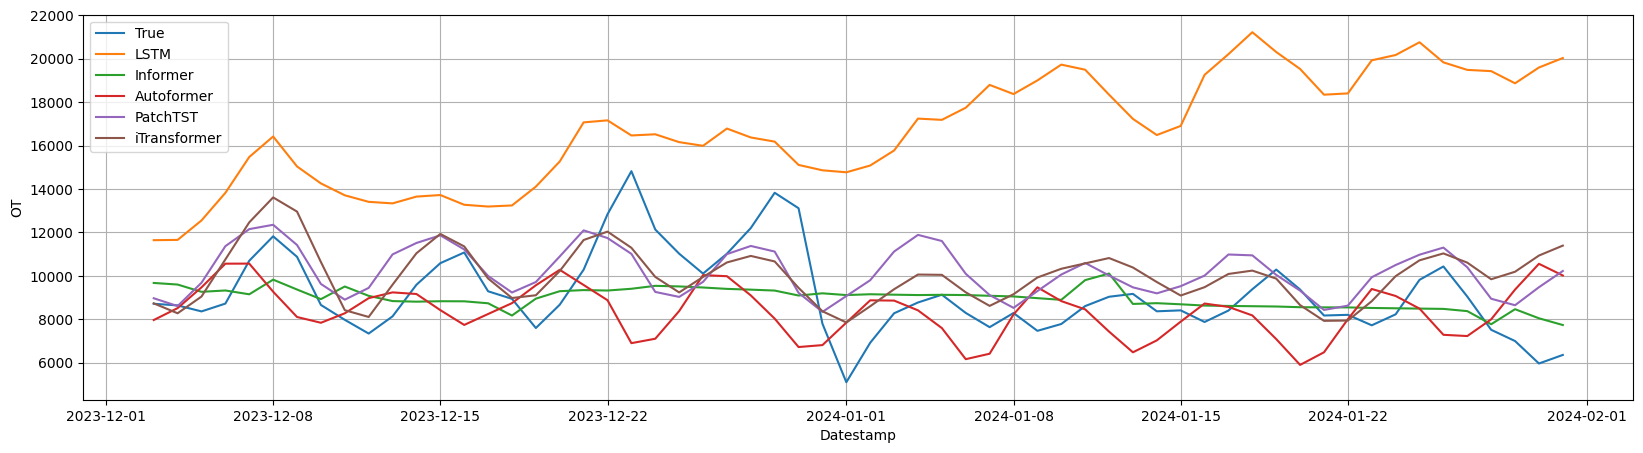

In [30]:
from matplotlib import pyplot as plt

Y_plot = cross_val[cross_val['unique_id'] == 'global_entry']
cutoffs = cross_val['cutoff'].unique()[::horizon]
Y_plot = Y_plot[cross_val['cutoff'].isin(cutoffs)]
Y_plot = Y_plot[-365:]

plt.figure(figsize=(20, 5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['AutoLSTM'], label='LSTM')
plt.plot(Y_plot['ds'], Y_plot['AutoInformer'], label='Informer')
plt.plot(Y_plot['ds'], Y_plot['AutoAutoformer'], label='Autoformer')
plt.plot(Y_plot['ds'], Y_plot['AutoPatchTST'], label='PatchTST')
plt.plot(Y_plot['ds'], Y_plot['AutoiTransformer'], label='iTransformer')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()


In [31]:
from neuralforecast.losses.numpy import mae, rmse, mape


model_names = ['AutoLSTM', 'AutoInformer', 'AutoAutoformer', 'AutoPatchTST', 'AutoiTransformer']


def eval_accuracy(df):
    unique_ids = df['unique_id'].unique()
    for unique_id in unique_ids:
        df_tmp = df[df['unique_id'] == unique_id]
        print(unique_id)
        y_true = df_tmp['y']
        for model_name in model_names:
            y_pred = df_tmp[model_name]
            print(
                f'{model_name} -- mae: {mae(y_true, y_pred)},rmse: {rmse(y_true, y_pred)}, mape: {mape(y_true, y_pred)}')


eval_accuracy(cross_val)

global_entry
AutoLSTM -- mae: 7569.386637369792,rmse: 8263.808321472956, mape: 0.9054308142862616
AutoInformer -- mae: 1357.7743001302083,rmse: 1744.4116119042742, mape: 0.14713320224770143
AutoAutoformer -- mae: 1869.9282145182292,rmse: 2478.290910914552, mape: 0.20023821373393919
AutoPatchTST -- mae: 1599.6083658854166,rmse: 1936.6811848644368, mape: 0.1885311248990315
AutoiTransformer -- mae: 1480.8044189453126,rmse: 1827.8185760380827, mape: 0.17349718567603006
hkmo_entry
AutoLSTM -- mae: 526.9564270019531,rmse: 614.4546098623248, mape: 0.4173811675776159
AutoInformer -- mae: 403.18740030924477,rmse: 494.5436066865171, mape: 0.27359621554125296
AutoAutoformer -- mae: 442.3763437906901,rmse: 594.7910918881117, mape: 0.28010169944470154
AutoPatchTST -- mae: 435.25853068033854,rmse: 517.5135284770059, mape: 0.34678771559254906
AutoiTransformer -- mae: 425.951171875,rmse: 494.079389372914, mape: 0.34069237158473337
tw_entry
AutoLSTM -- mae: 669.5123250325521,rmse: 762.2129811955547, ma

In [32]:
nf.save('./models', model_index=[0, 1, 2, 3, 4], overwrite=False, save_dataset=True)

In [33]:
df_pred = nf.predict(df_long)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

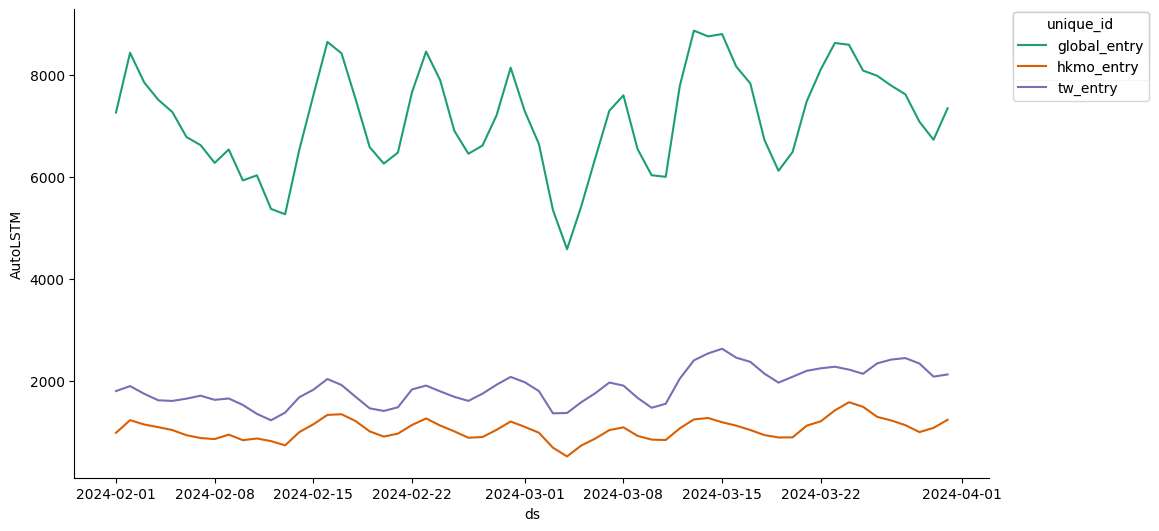

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['AutoPatchTST']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_pred.sort_values('ds', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('unique_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='unique_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('AutoLSTM')

In [47]:
!zip -r lightning_logs.zip /content/lightning_logs

  adding: content/lightning_logs/ (stored 0%)
  adding: content/lightning_logs/version_4/ (stored 0%)
  adding: content/lightning_logs/version_4/hparams.yaml (deflated 71%)
  adding: content/lightning_logs/version_4/events.out.tfevents.1713484249.c5b191df96a7.2412.4 (deflated 69%)
  adding: content/lightning_logs/version_2/ (stored 0%)
  adding: content/lightning_logs/version_2/hparams.yaml (deflated 71%)
  adding: content/lightning_logs/version_2/events.out.tfevents.1713483829.c5b191df96a7.2412.2 (deflated 69%)
  adding: content/lightning_logs/version_10/ (stored 0%)
  adding: content/lightning_logs/version_10/events.out.tfevents.1713484797.c5b191df96a7.2412.10 (deflated 69%)
  adding: content/lightning_logs/version_10/hparams.yaml (deflated 66%)
  adding: content/lightning_logs/version_16/ (stored 0%)
  adding: content/lightning_logs/version_16/events.out.tfevents.1713485379.c5b191df96a7.2412.16 (deflated 69%)
  adding: content/lightning_logs/version_16/hparams.yaml (deflated 65%)
  